# About the Data (from [here](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95))

The Motor Vehicle Collisions crash table contains details on the crash event. Each row represents a crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. The police report (MV104-AN) is required to be filled out for collisions where someone is injured or killed, or where there is at least $1000 worth of damage (https://www.nhtsa.gov/sites/nhtsa.dot.gov/files/documents/ny_overlay_mv-104an_rev05_2004.pdf). It should be noted that the data is preliminary and subject to change when the MV-104AN forms are amended based on revised crash details.For the most accurate, up to date statistics on traffic fatalities, please refer to the NYPD Motor Vehicle Collisions page (updated weekly) or Vision Zero View (updated monthly).


Due to success of the CompStat program, NYPD began to ask how to apply the CompStat principles to other problems. Other than homicides, the fatal incidents with which police have the most contact with the public are fatal traffic collisions. Therefore in April 1998, the Department implemented TrafficStat, which uses the CompStat model to work towards improving traffic safety. Police officers complete form MV-104AN for all vehicle collisions. The MV-104AN is a New York State form that has all of the details of a traffic collision. Before implementing Trafficstat, there was no uniform traffic safety data collection procedure for all of the NYPD precincts. Therefore, the Police Department implemented the Traffic Accident Management System (TAMS) in July 1999 in order to collect traffic data in a uniform method across the City. TAMS required the precincts manually enter a few selected MV-104AN fields to collect very basic intersection traffic crash statistics which included the number of accidents, injuries and fatalities. As the years progressed, there grew a need for additional traffic data so that more detailed analyses could be conducted. The Citywide traffic safety initiative, Vision Zero started in the year 2014. Vision Zero further emphasized the need for the collection of more traffic data in order to work towards the Vision Zero goal, which is to eliminate traffic fatalities. Therefore, the Department in March 2016 replaced the TAMS with the new Finest Online Records Management System (FORMS). FORMS enables the police officers to electronically, using a Department cellphone or computer, enter all of the MV-104AN data fields and stores all of the MV-104AN data fields in the Department’s crime data warehouse. Since all of the MV-104AN data fields are now stored for each traffic collision, detailed traffic safety analyses can be conducted as applicable.


In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from aux import *


df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')
df = df.loc[~df['LOCATION'].isna()]
df = df.loc[~(df['LOCATION'] == '(0.0, 0.0)')]

df['ZIP CODE'] = df['ZIP CODE'].astype(str).replace('     ','nan').astype(float)

df = haversine_KNN_impute(df, 'ZIP CODE')
df = haversine_KNN_impute(df, 'BOROUGH')

df['ZIP CODE'] = df['ZIP CODE'].astype(int)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Where does it happen?

<BarContainer object of 5 artists>

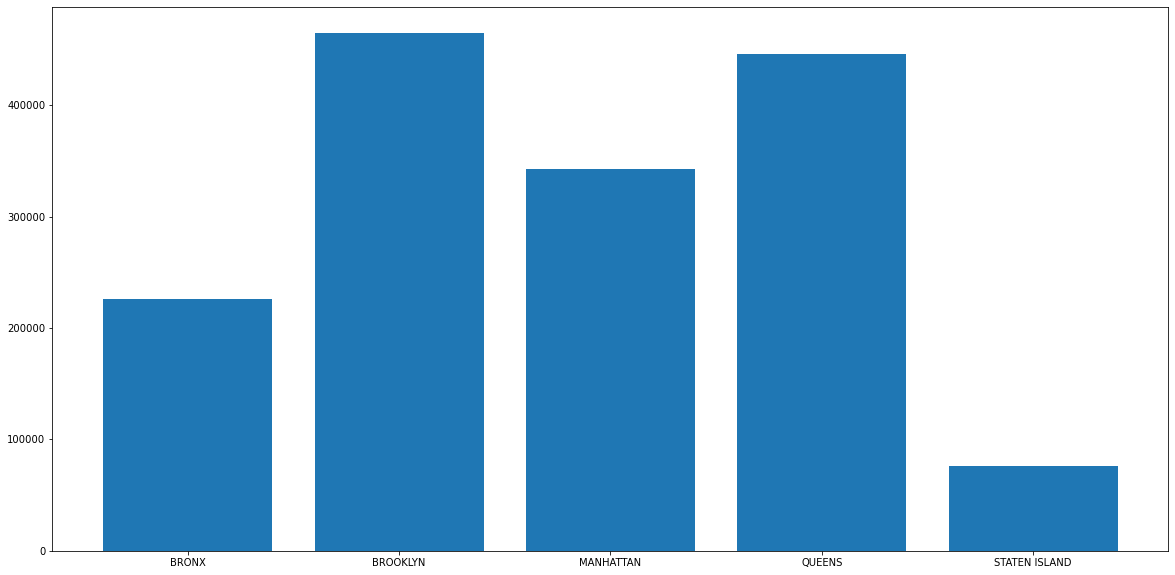

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(list(df.groupby('BOROUGH').size().index), df.groupby('BOROUGH').size().values)

In [50]:
import folium
from folium.plugins import HeatMap

#coords = df.loc[df['Category'] == 'SEX OFFENSES, NON FORCIBLE']['location']\
#            .apply(lambda x : [float(y) for y in x.replace('POINT (','').replace(')','').split(' ')])\
#            .values.tolist()

lat, lon = df[['LATITUDE', 'LONGITUDE']].mean(axis=0)
ny_map = folium.Map([lat, lon],
                    zoom_start = 11.75,
                    tiles = "Stamen Toner")

coords = df[['LATITUDE', 'LONGITUDE']].iloc[:500,:].values.tolist()
# Plot it on the map

#From the documentation:
#radius (int, default 25) – Radius of each “point” of the heatmap
#max_zoom (default 18) – Zoom level where the points reach maximum intensity (as intensity scales with zoom), equals maxZoom of the map by default

HeatMap(coords,radius=15).add_to(ny_map)

#The center of the heatmaps draw a lot of attention. Outliers are harder to spot.
#That being said, when points are stacked, it's hard to see exactly how many there are. 
ny_map

## Investigation into injury


In [90]:
injury_columns = [x for x in df.columns if x.startswith('NUMBER OF ')]

for injury in injury_columns:
    print(injury.title())
    n, nocc = df.groupby(injury).size().index, df.groupby(injury).size().values
    for i, j in zip(n, nocc/nocc.sum()):
        print(f'{int(i)}, {j}')
    print('')

Number Of Persons Injured
0, 0.7976347342723777
1, 0.15766959812722478
2, 0.02901464616144073
3, 0.009548993871829054
4, 0.0036027268882338347
5, 0.0014153799478841935
6, 0.0005772076263396938
7, 0.0002577508442786383
8, 0.00011119924204539758
9, 5.334992537438149e-05
10, 4.0494521669711256e-05
11, 2.1211416112705894e-05
12, 1.60692546308378e-05
13, 1.0284322963736192e-05
14, 3.21385092616756e-06
15, 4.499391296634584e-06
16, 4.499391296634584e-06
17, 2.571080740934048e-06
18, 2.571080740934048e-06
19, 1.928310555700536e-06
20, 1.285540370467024e-06
22, 1.928310555700536e-06
24, 1.928310555700536e-06
27, 6.42770185233512e-07
32, 6.42770185233512e-07
43, 6.42770185233512e-07

Number Of Persons Killed
0, 0.9988102232100962
1, 0.0011531386067463107
2, 2.8282106297010966e-05
3, 5.142201144911085e-06
4, 1.9283254293416567e-06
5, 6.427751431138856e-07
8, 6.427751431138856e-07

Number Of Pedestrians Injured
0, 0.9482208947011856
1, 0.04991509093176293
2, 0.0016409754065800993
3, 0.00017354616

## Contributing Factors

In [117]:
contributing = [x for x in df.columns if x.startswith('CONTRIBUTING FACTOR')]

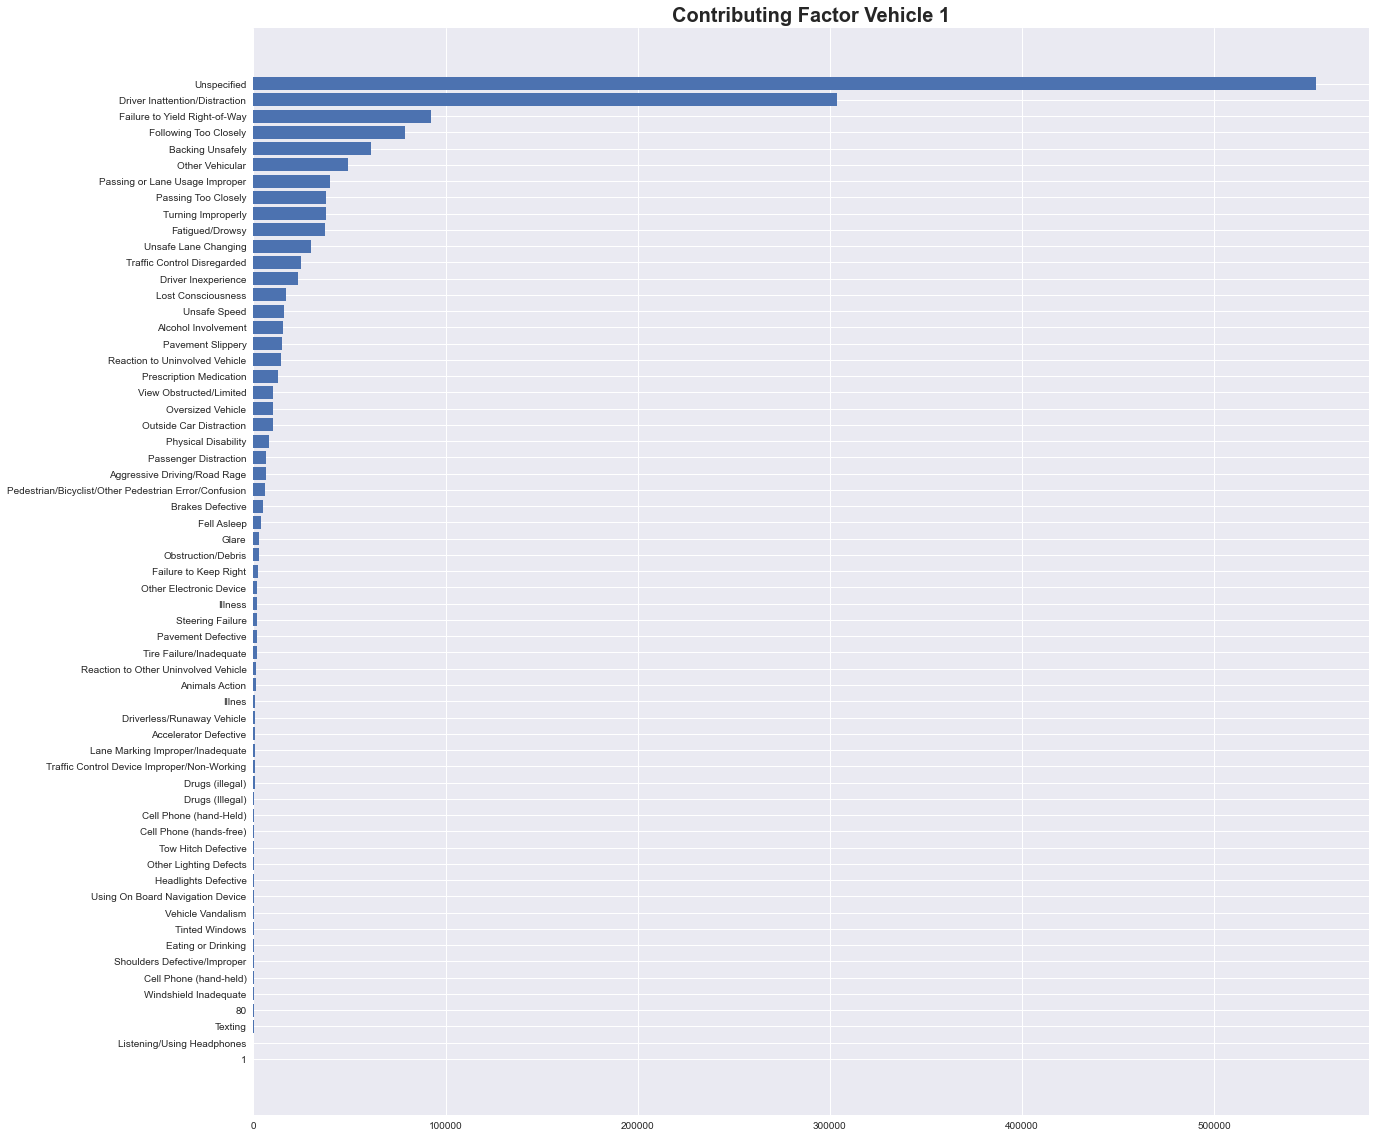

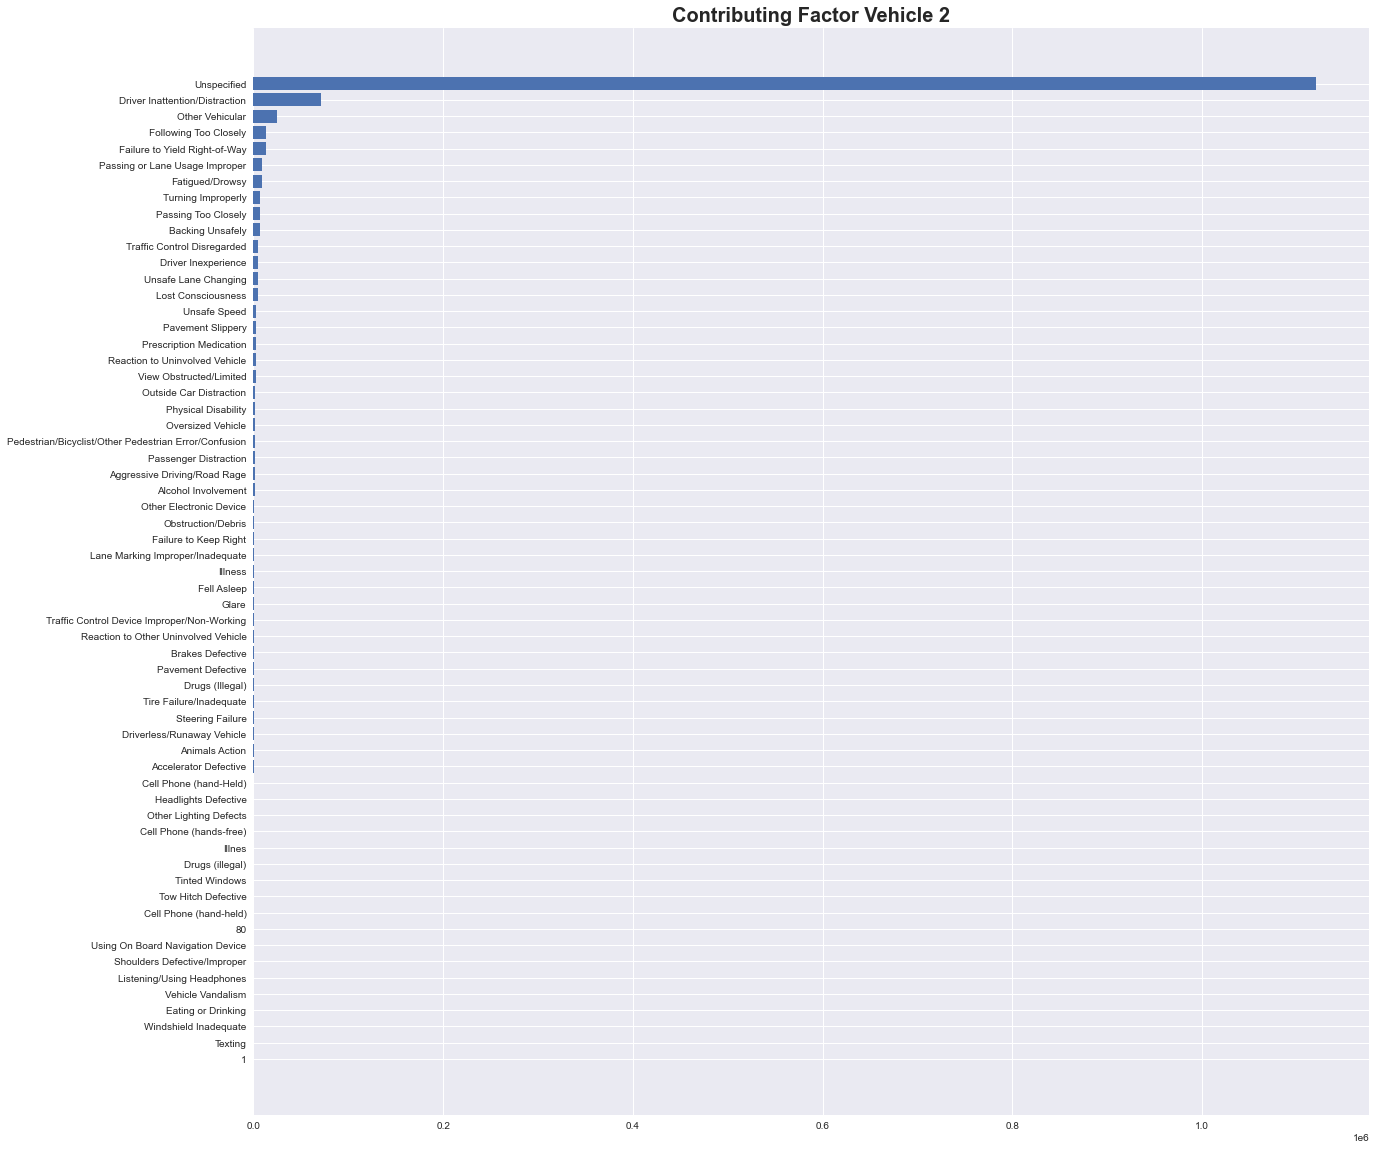

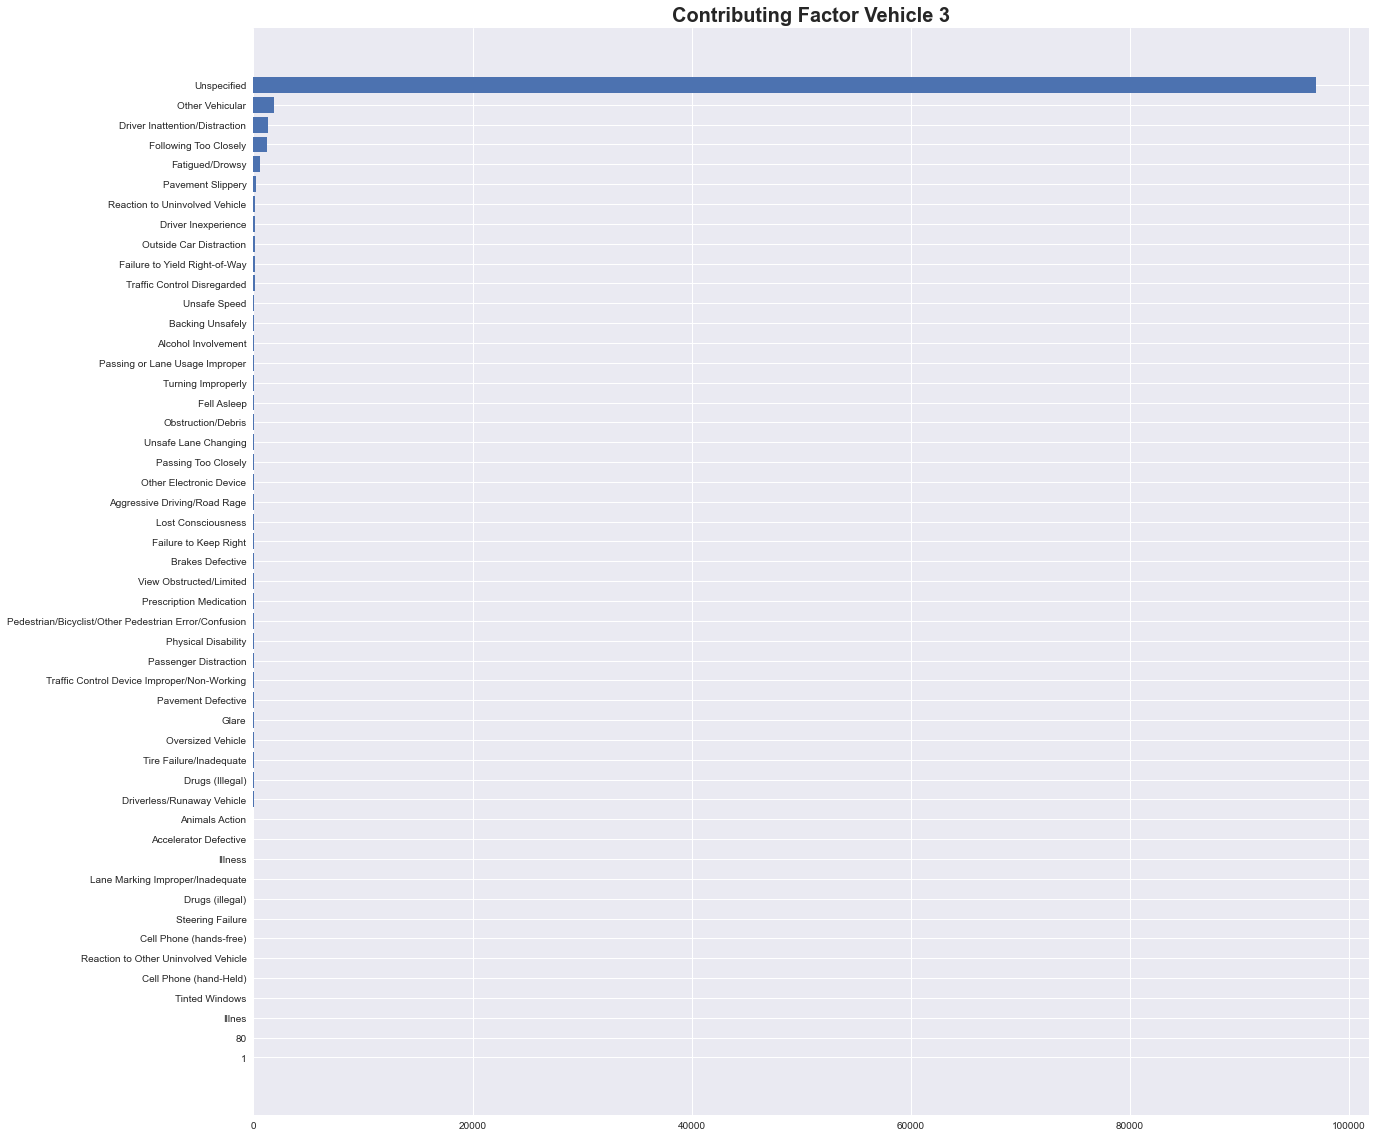

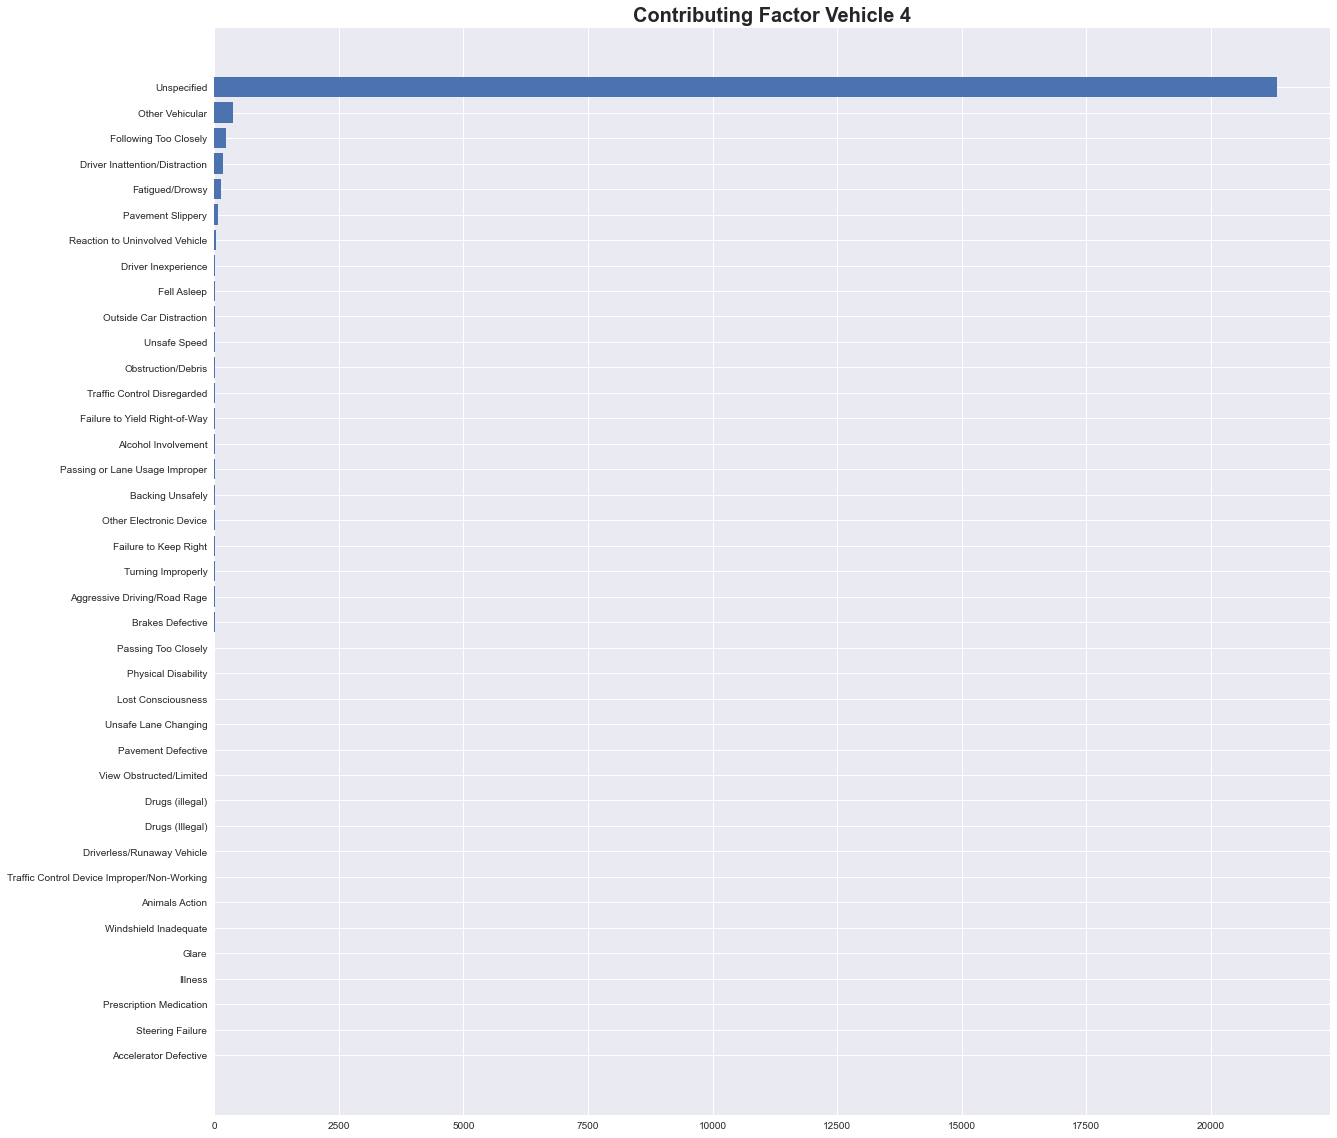

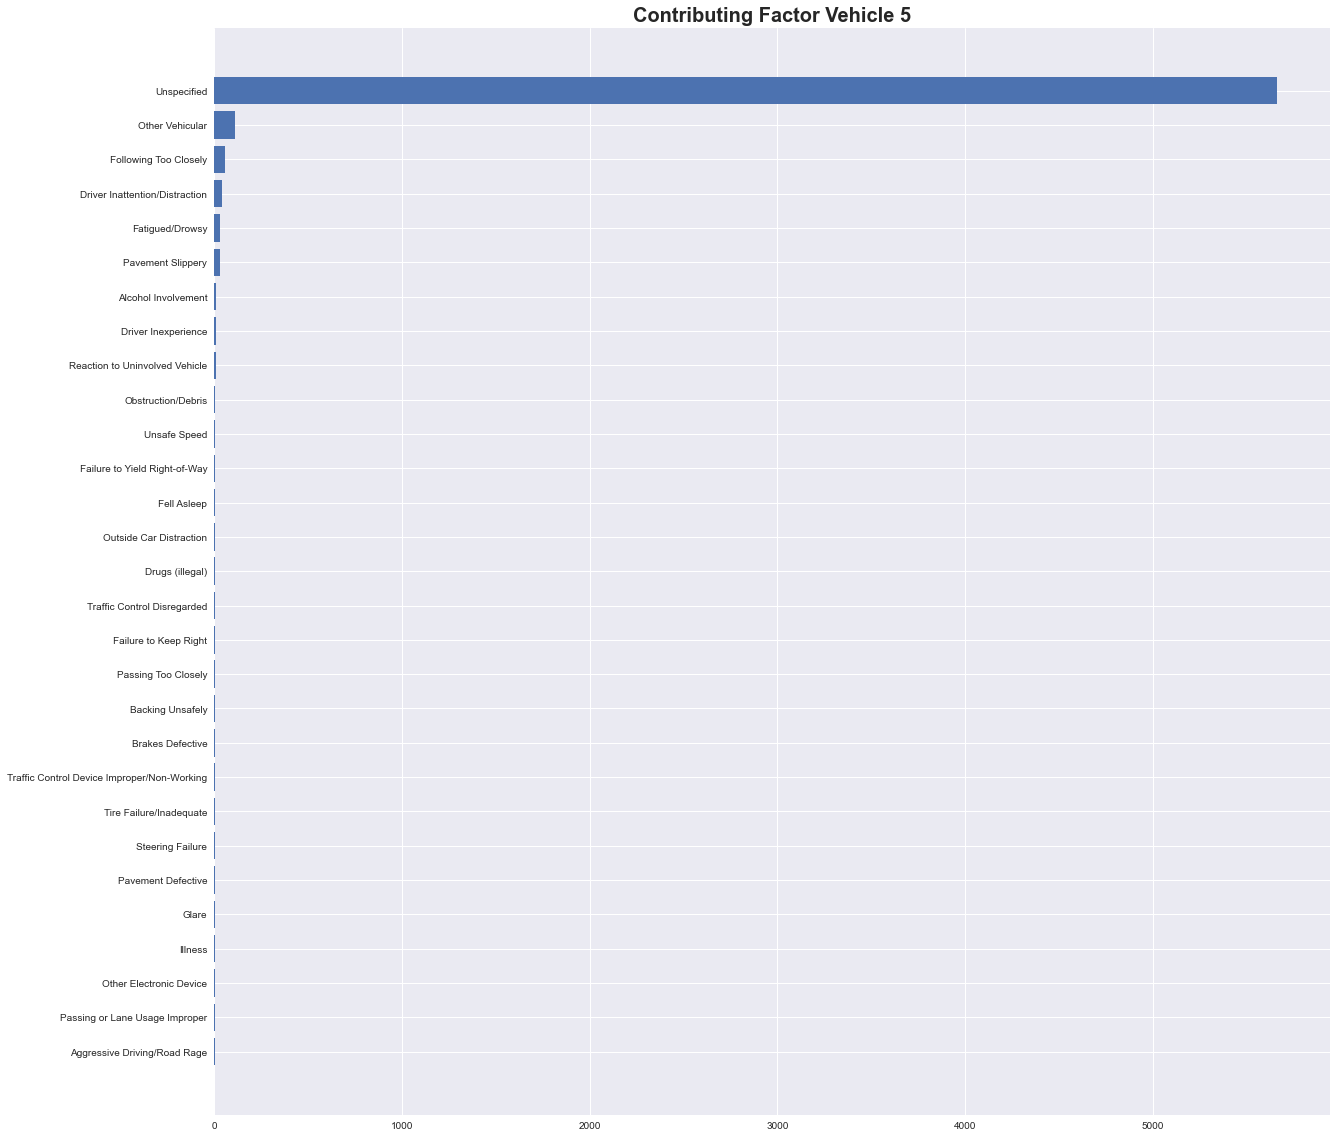

In [118]:
plt.style.use('seaborn')

for contribute in contributing:
    reason, nocc = df.groupby(contribute).size().index, df.groupby(contribute).size().values
    idxsort = nocc.argsort()
    plt.figure(figsize=(20,20))
    plt.title(contribute.title(), fontsize=20, fontweight='bold')
    plt.barh(reason[idxsort], nocc[idxsort])
    plt.show()

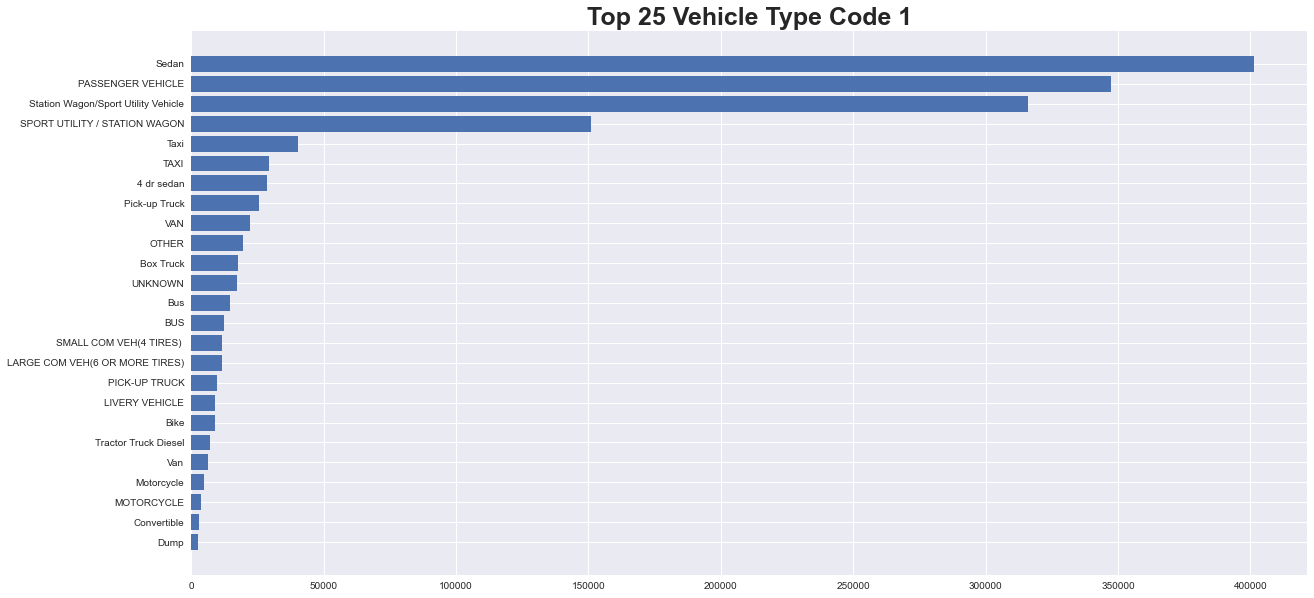

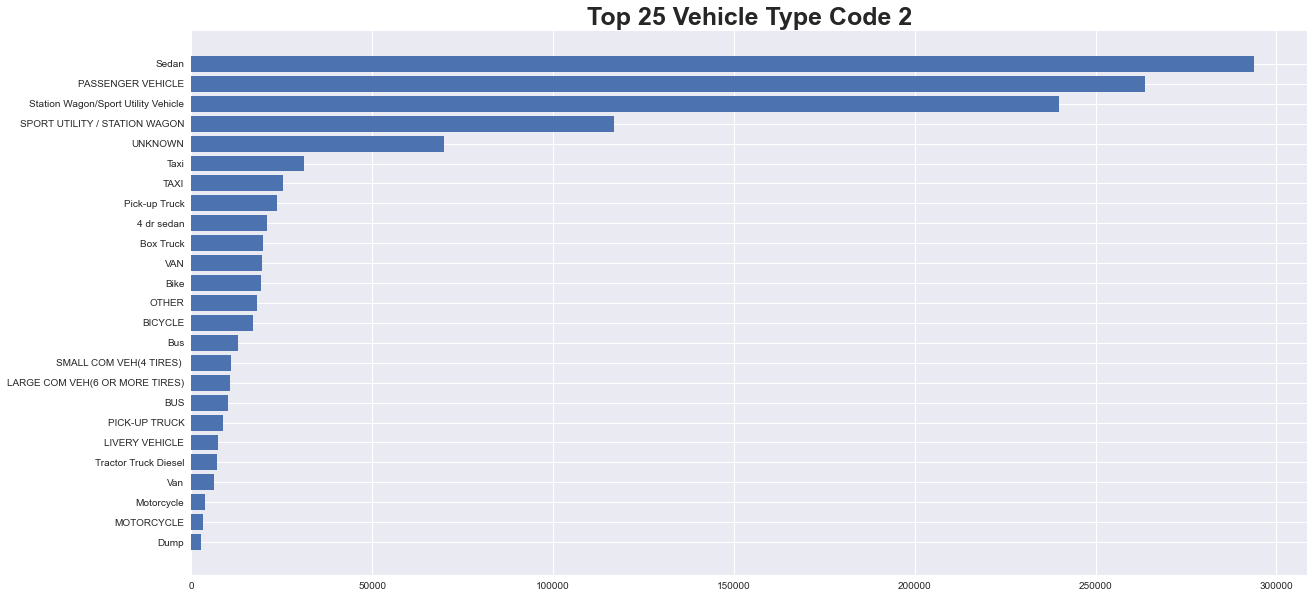

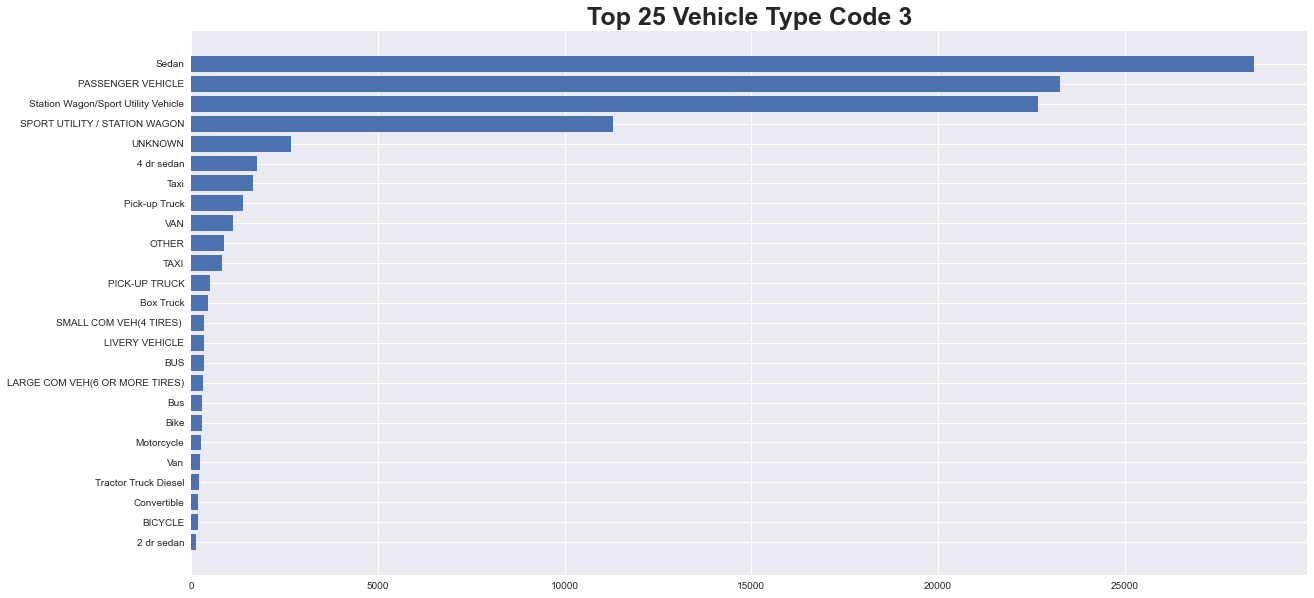

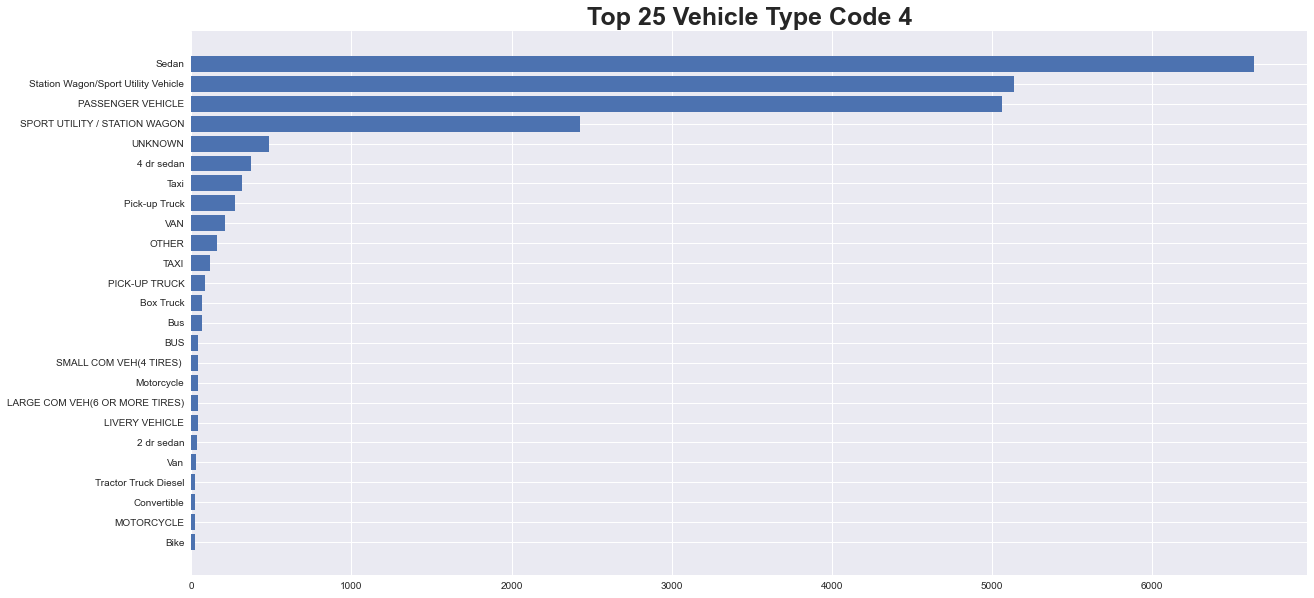

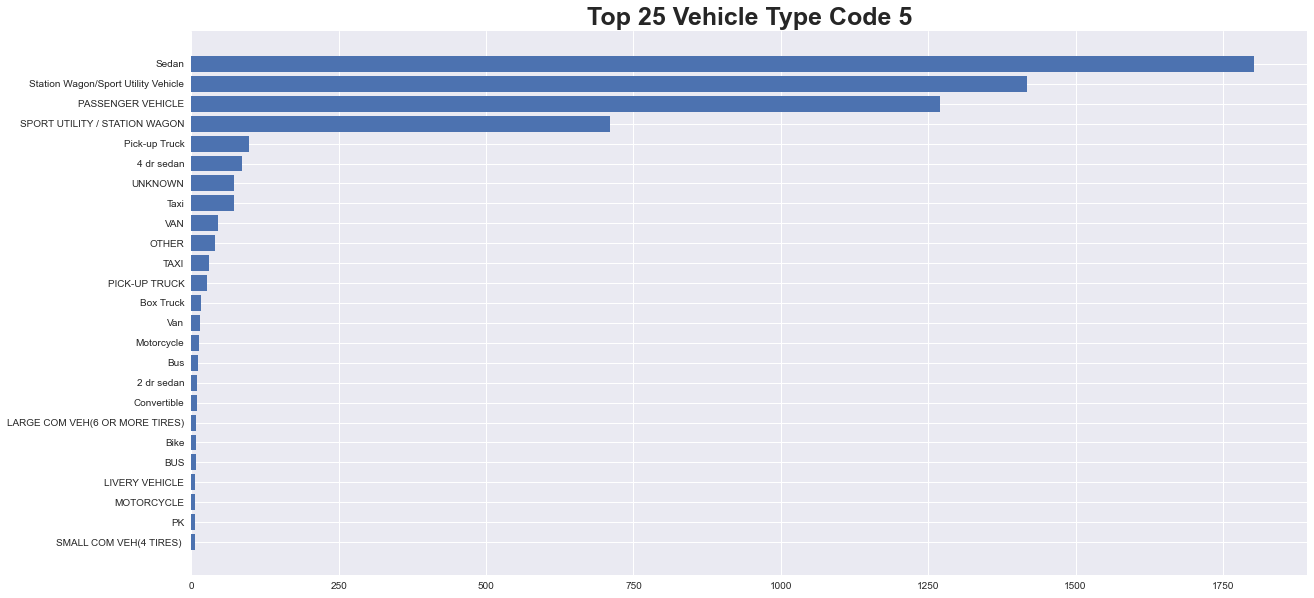

In [180]:
vehicle_type_columns = [x for x in df.columns if x.startswith('VEHICLE TYPE CODE')]

for col in vehicle_type_columns:
    
    vehicletype, nocc = df.groupby(col).size().index, df.groupby(col).size().values
    
    #Top 25
    vehicletype = vehicletype[(-nocc).argsort()]
    nocc        = nocc[(-nocc).argsort()]
    
    plt.figure(figsize=(20,10))
    plt.barh(vehicletype[:25], nocc[:25])
    ax = plt.gca()
    ax.invert_yaxis()
    plt.title(f'Top 25 {col.title()}', fontsize=25, fontweight='bold')
    plt.show()